In [224]:
import numba
import healpy
import numpy as np

from tqdm          import tqdm
from scipy.spatial import KDTree
from astropy       import constants

In [8]:
input_file = "/STER/frederikd/Magritte-examples/Phantom_3D/model_Phantom_3D.ascii"

In [11]:
# Read the Phantom ascii file
(x,y,z, h, rho, vx,vy,vz, u) = np.loadtxt(input_file, skiprows=14, usecols=(0,1,2,4,5,6,7,8,9), unpack=True)

# Constants that can be read from ascii file
velocity_cte = 2.9784608e+06
density_cte  = 5.9410314e-07
energy_cte   = 8.8712277e+12

keep = np.logical_and(h>0.0, rho>0.0)

x_m1, y_m1, z_m1 = x[-1], y[-1], z[-1]
x_m2, y_m2, z_m2 = x[-2], y[-2], z[-2]

# Exclude unphysical points and points with zero abundance
x   = x  [keep]
y   = y  [keep]
z   = z  [keep]
vx  = vx [keep]
vy  = vy [keep]
vz  = vz [keep]
u   = u  [keep]
rho = rho[keep]

# Extract the number of points
npoints = len(x)

position = np.array((x, y, z )).transpose()
velocity = np.array((vx,vy,vz)).transpose()

# Convert units
position *= constants.au.si.value                    # Convert au to m
velocity *= (velocity_cte / constants.c.cgs.value)   # cm/s to c fraction

In [17]:
centre = np.array([x_m1, y_m1, z_m1])

In [10]:
tree = KDTree(position)

In [20]:
dists, order = tree.query(centre, k=npoints)

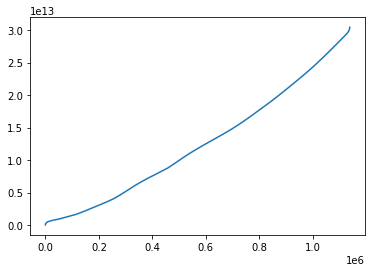

In [24]:
import matplotlib.pyplot as plt

plt.plot(dists)

In [159]:
dat = rho

In [161]:
dat.shape

(1138669,)

100%|██████████████████████████████████████| 49/49 [00:36<00:00,  1.35it/s]


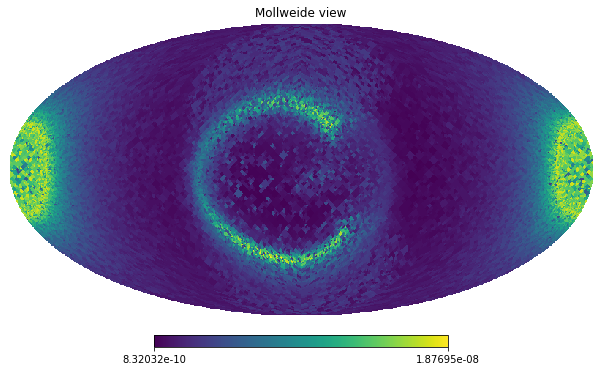

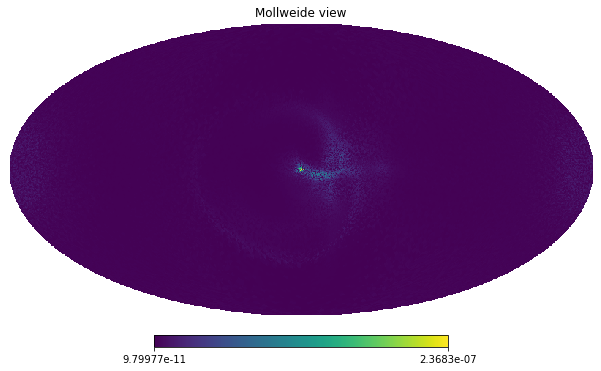

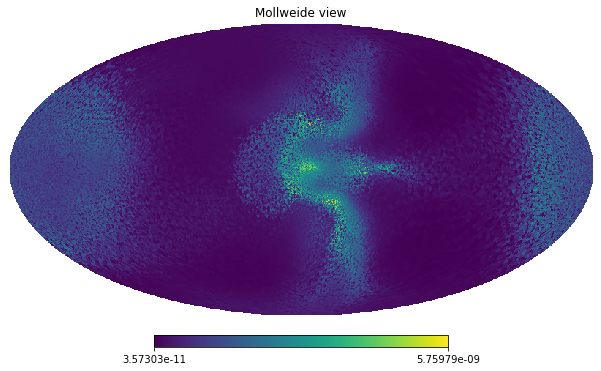

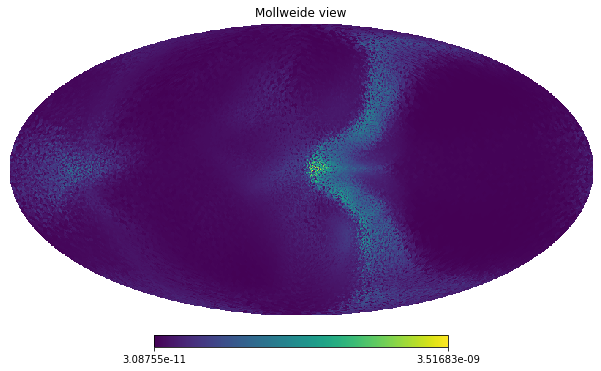

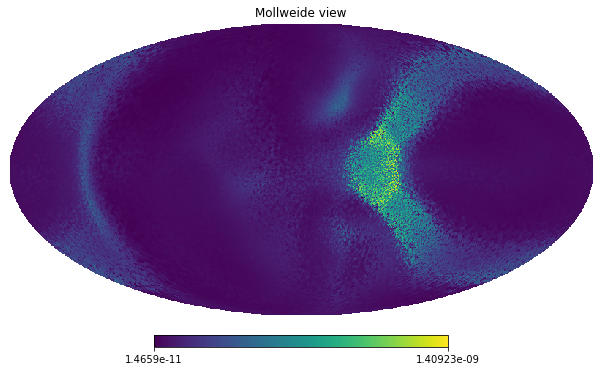

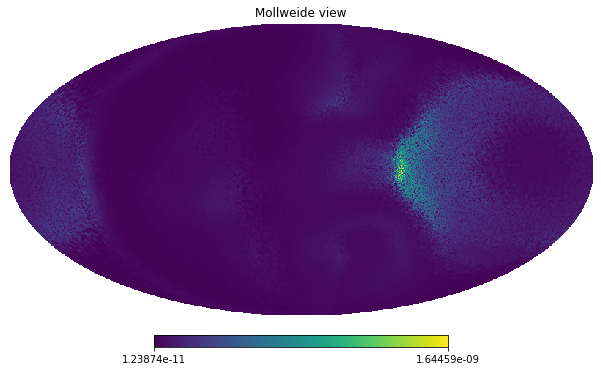

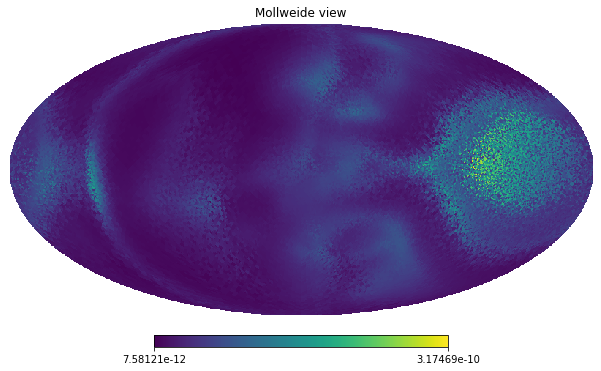

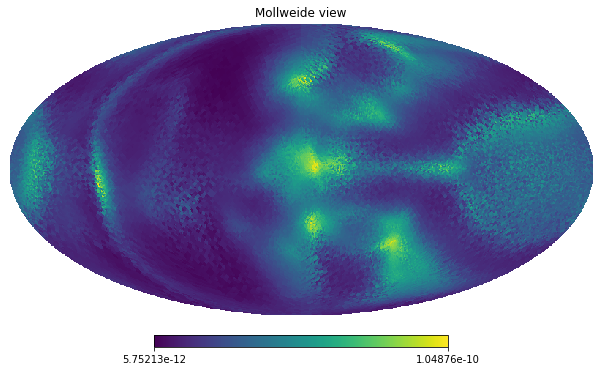

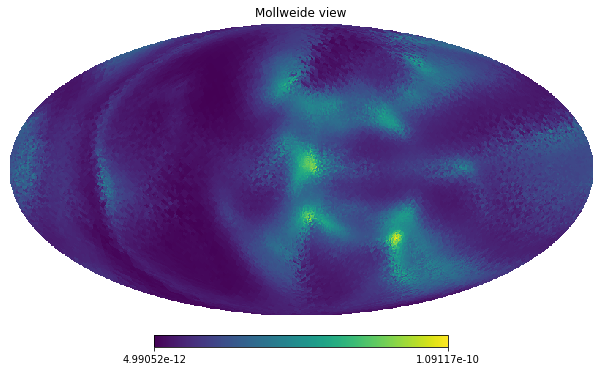

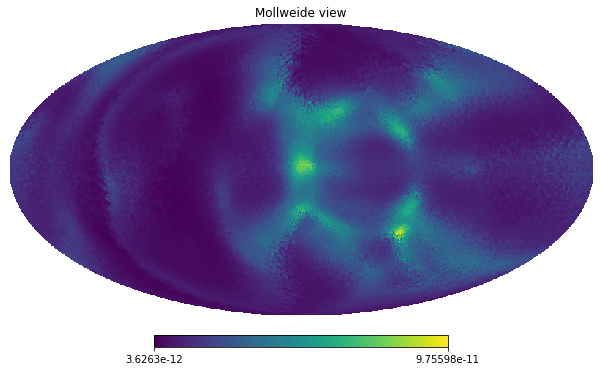

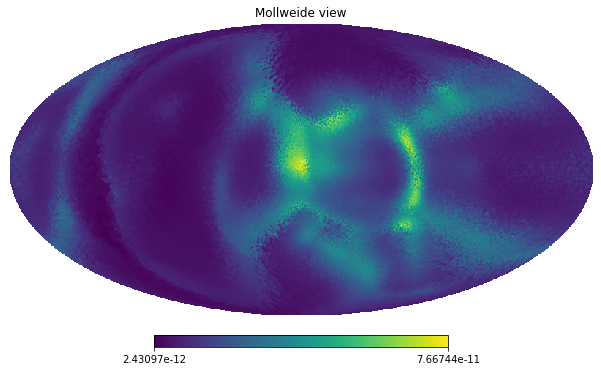

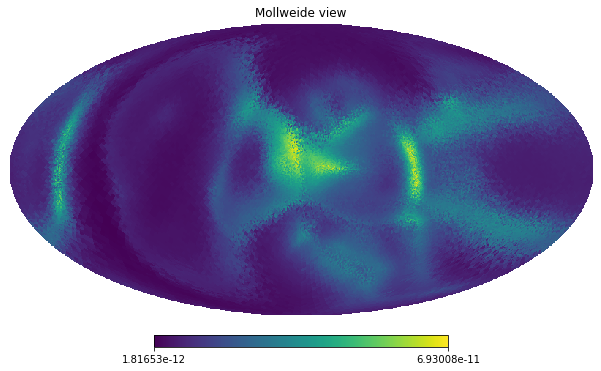

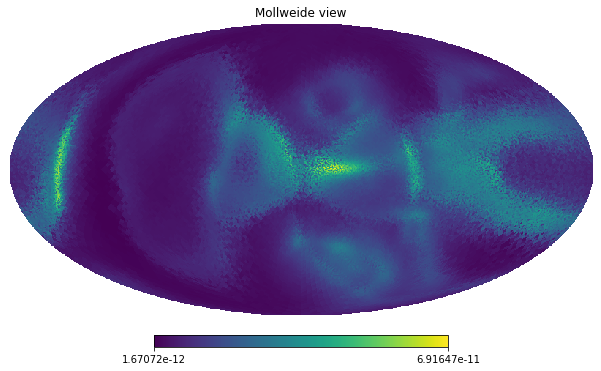

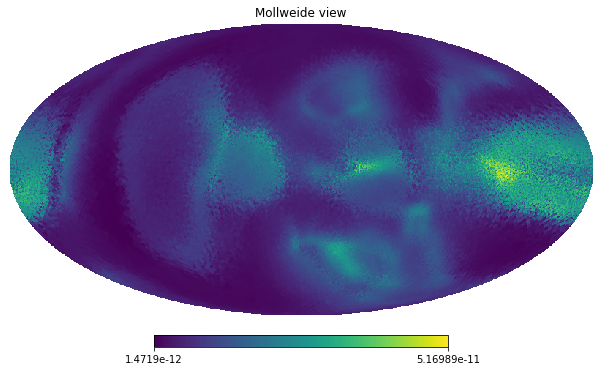

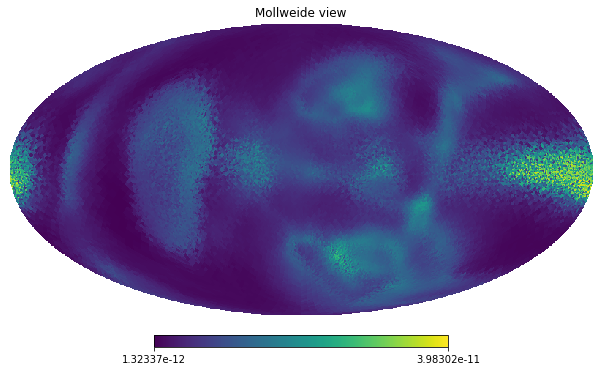

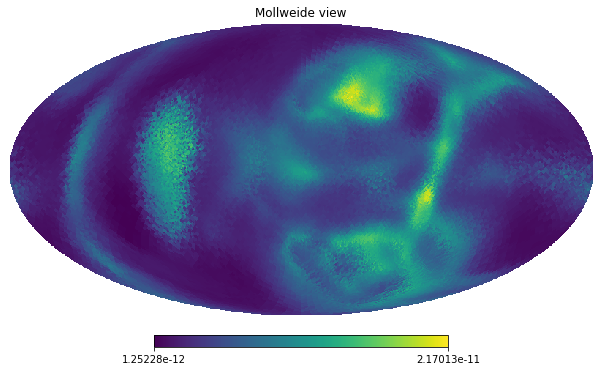

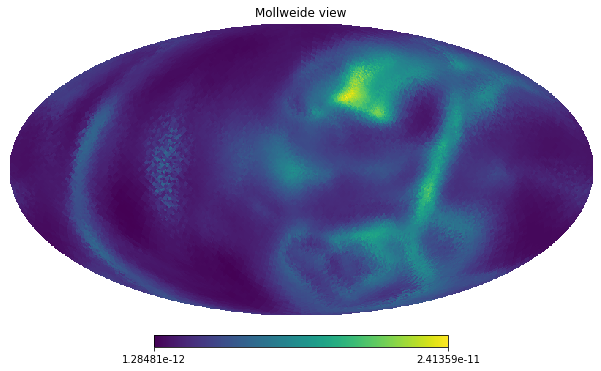

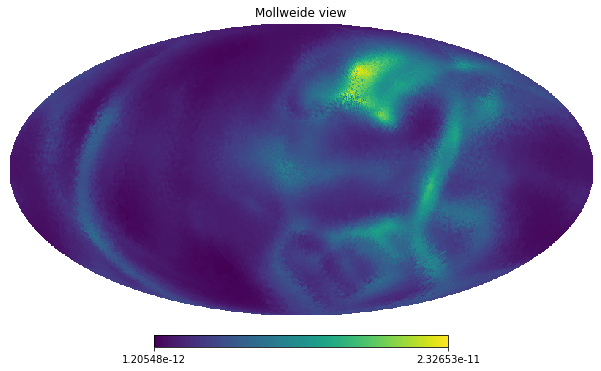

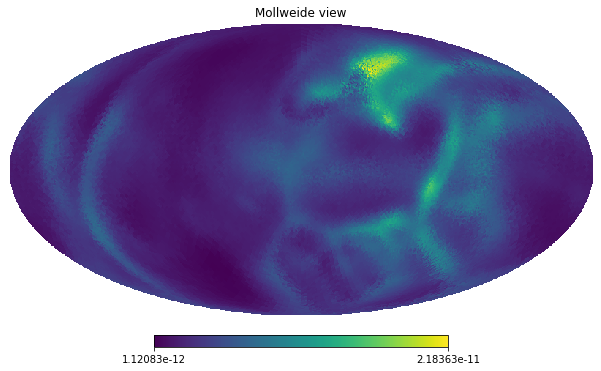

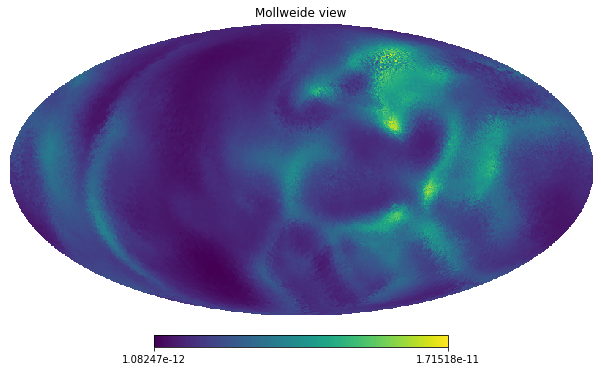

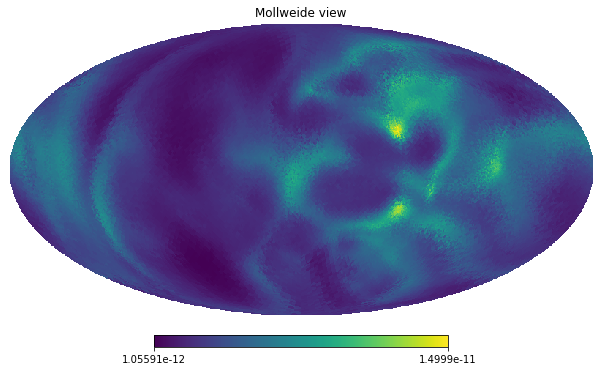

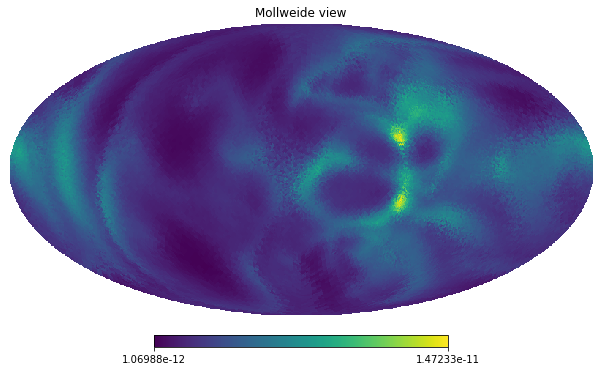

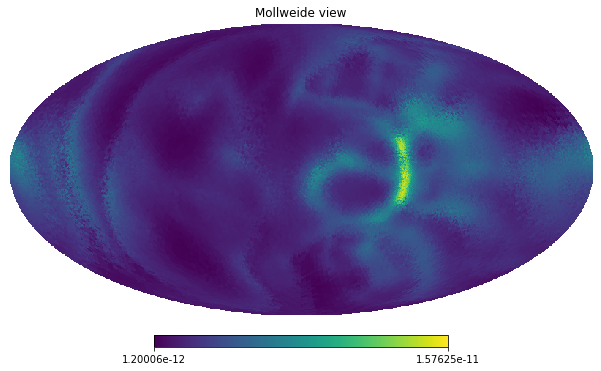

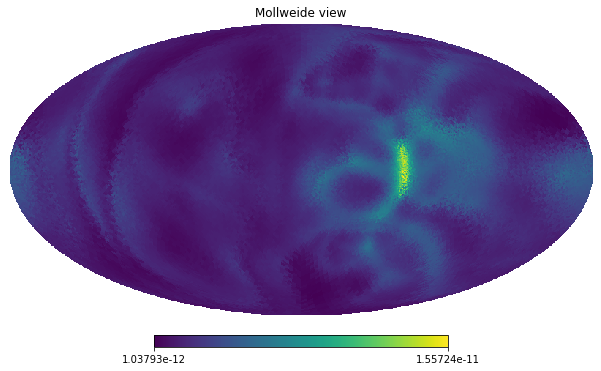

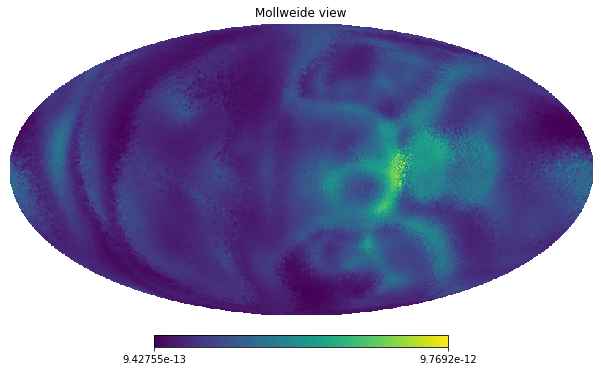

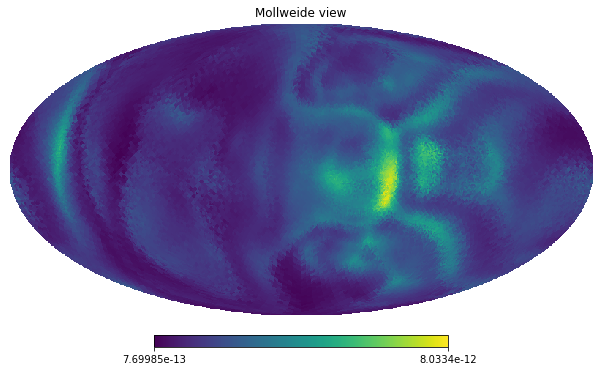

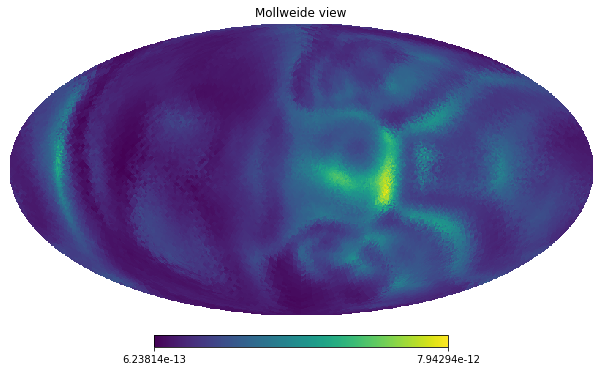

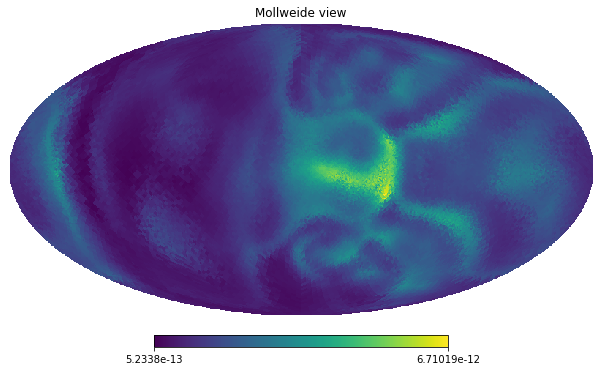

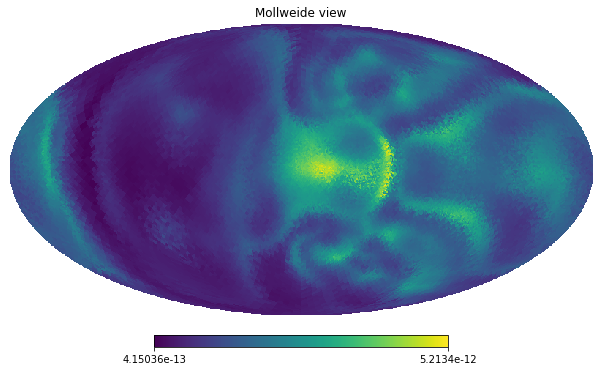

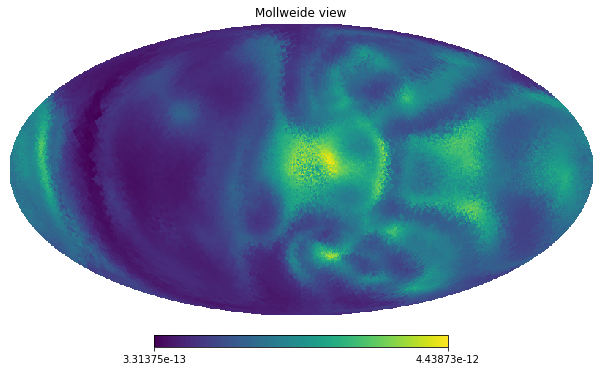

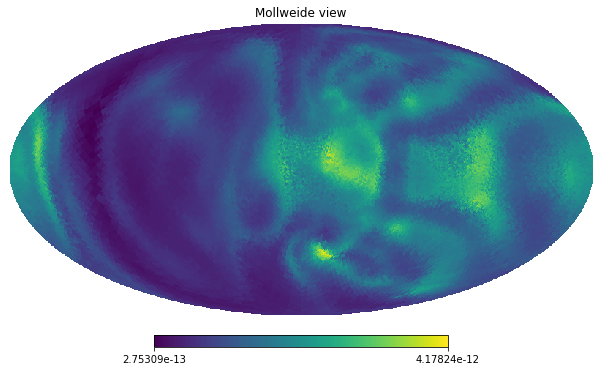

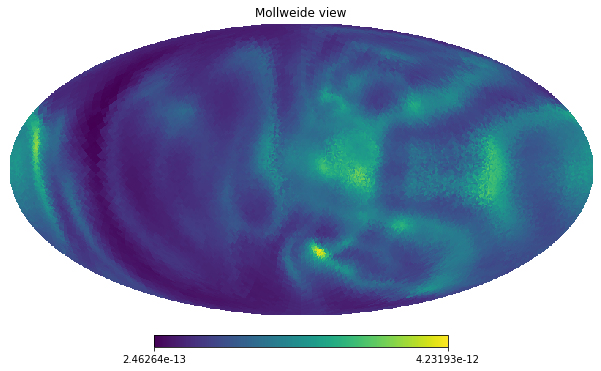

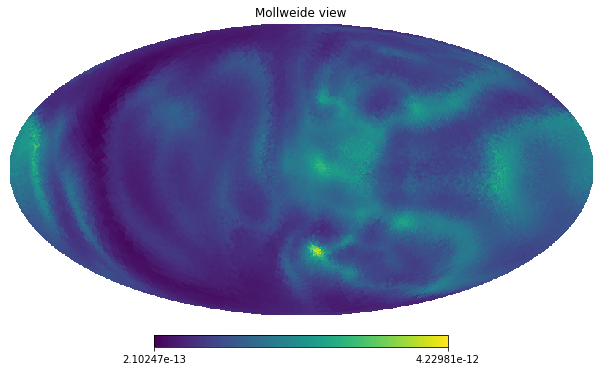

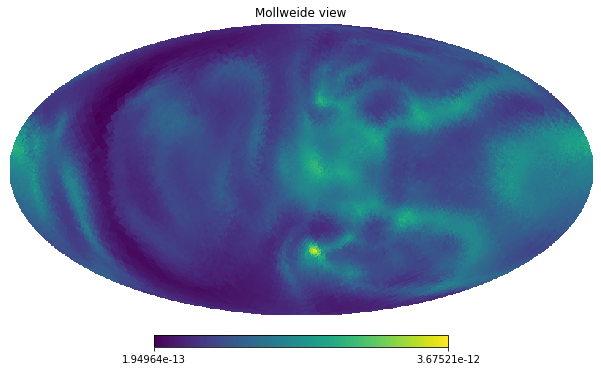

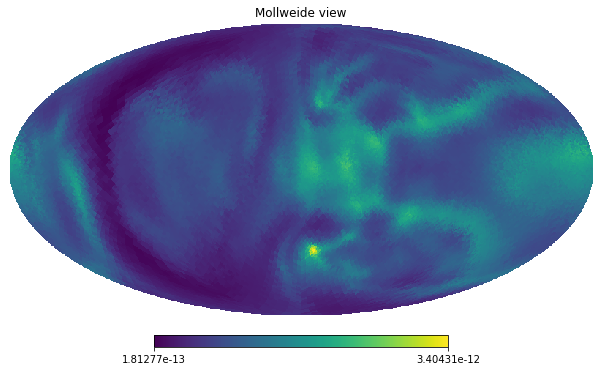

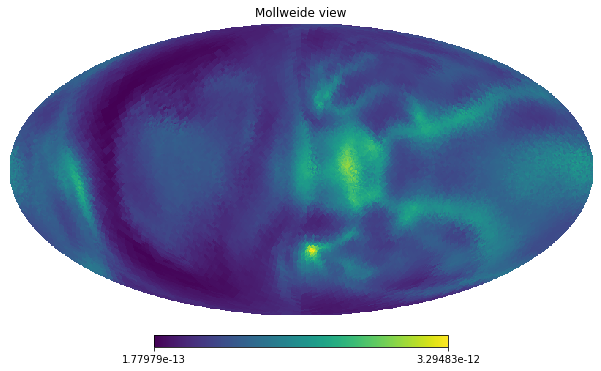

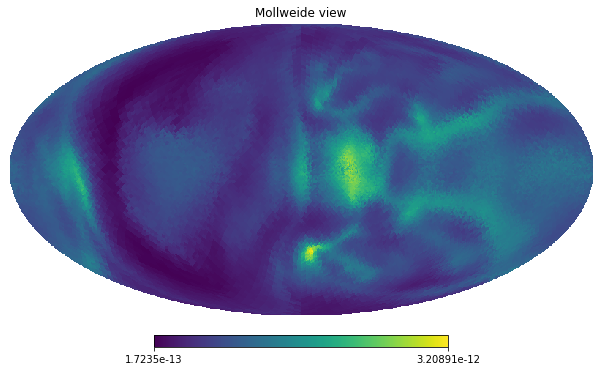

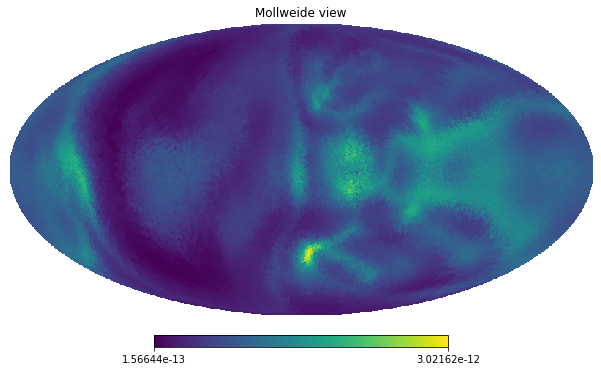

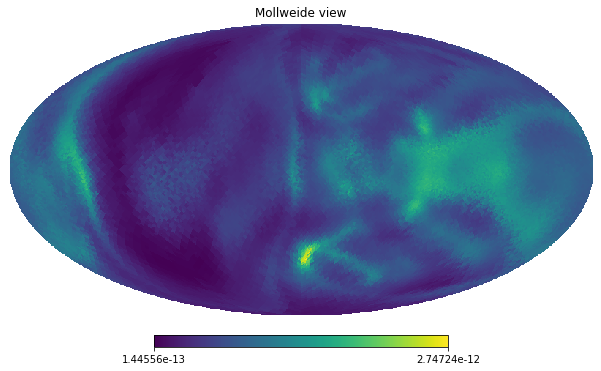

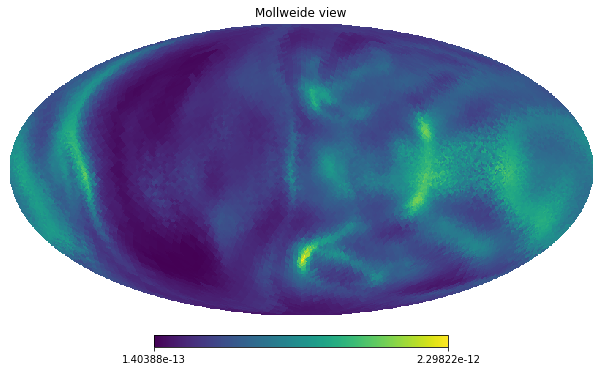

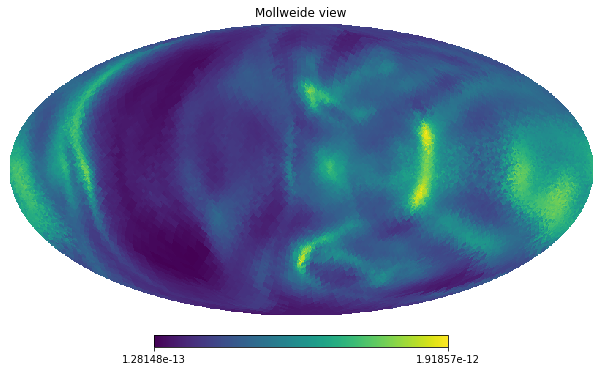

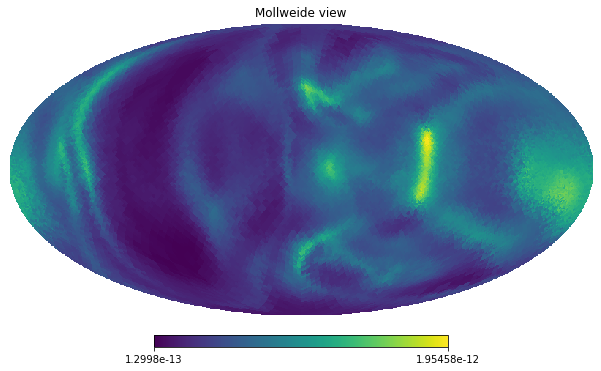

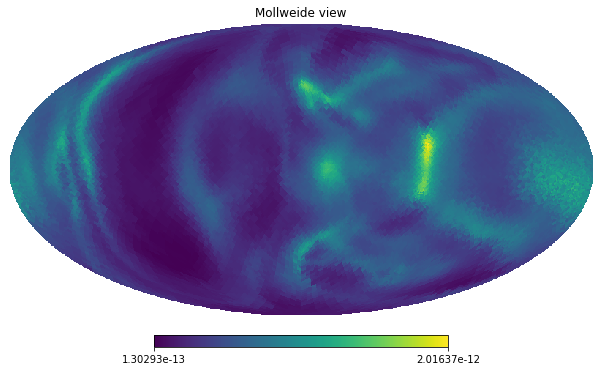

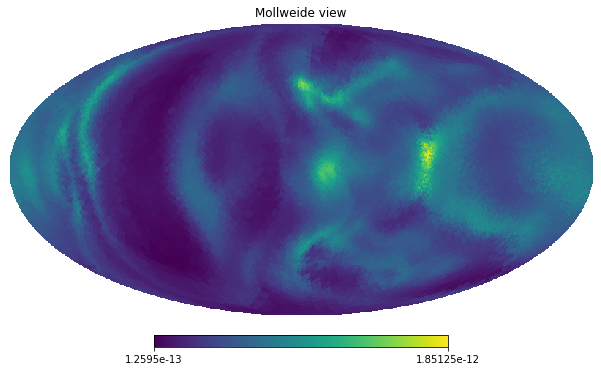

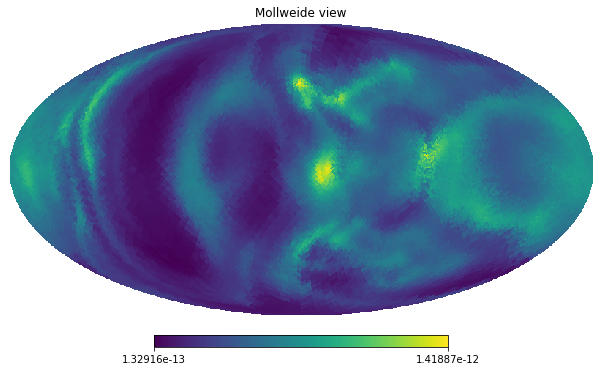

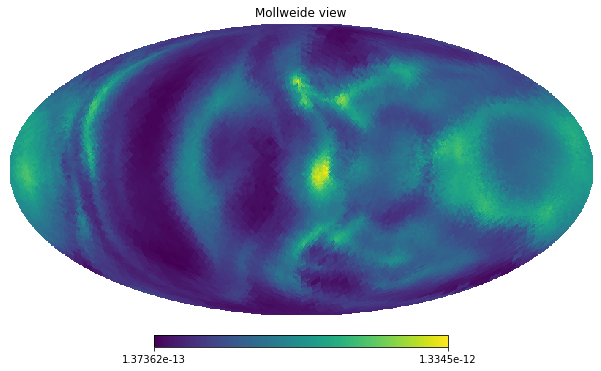

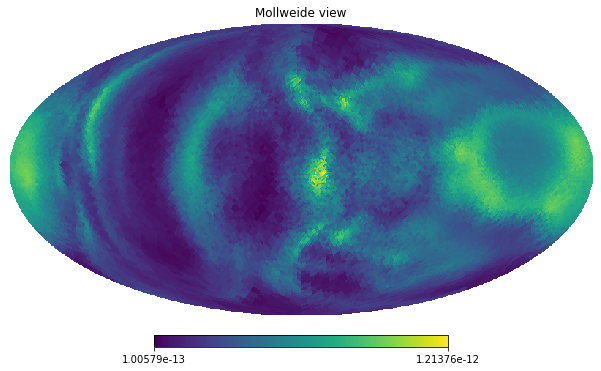

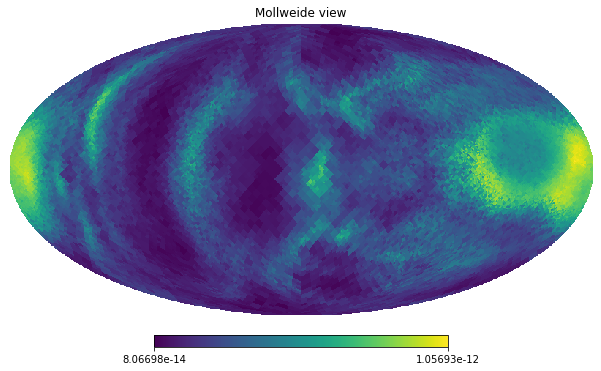

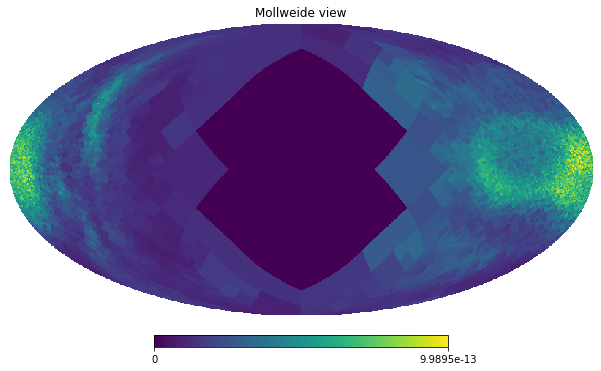

In [225]:
N     = 50
l_max = 8


lims = np.linspace(dists[0], dists[-1], N)

spec = []

for i in tqdm(range(N-1)):
    inds = order[np.logical_and(lims[i] <= dists, dists <= lims[i+1])]
    
    imgs, nums = create_img(l_max, x[inds], y[inds], z[inds], dat[inds])
    
#     imgs = []
#     nums = []
    
#     for l in range(1, l_max+1):
        
#         nside = 2**l
#         npix  = healpy.nside2npix(nside)
#         print(npix)
    
#         imap = healpy.vec2pix(nside, x[inds], y[inds], z[inds], nest=True)
    
#         img = np.zeros(npix)
#         num = np.zeros(npix)
    
#         img[imap] += dat[inds]
#         num[imap] += 1
    
#         img[num>0] /= num[num>0]
    
#         imgs.append(img)
#         nums.append(num)
    
    # break
    
    img = imgs[-1]
    
    # print(len(inds))
    healpy.visufunc.mollview(img, nest=True) 
    
    spec.append(healpy.anafast(healpy.remove_monopole(img, nest=False)))

spec = np.array(spec)

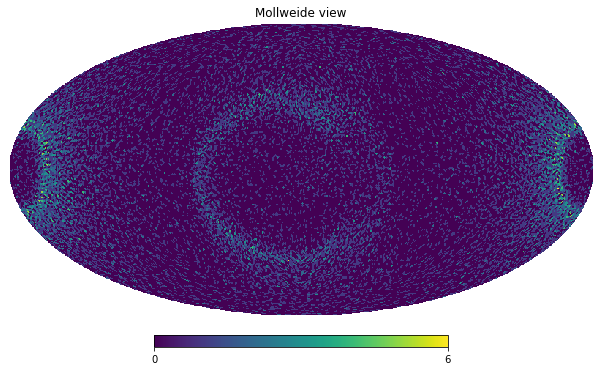

In [203]:
healpy.visufunc.mollview(nums[-1], nest=True) 

In [209]:
def create_img(l_max, x, y, z, dat):
    
    imgs = []
    nums = []
    
    for l in range(1, l_max+1):
        
        nside = 2**l
        npix  = healpy.nside2npix(nside)
    
        imap = healpy.vec2pix(nside, x, y, z, nest=True)
    
        img = np.zeros(npix)
        num = np.zeros(npix)
    
        for i, m in enumerate(imap):
            img[m] += dat[i]
            num[m] += 1.0
    
        for i, n in enumerate(num):
            if n > 0:
                img[i] /= n
    
        imgs.append(img)
        nums.append(num)
        
    
    for l in range(1, l_max):
        imgs[l][nums[l]==0] = imgs[l-1][np.where(nums[l]==0)[0]>>2]
        
    # print(nums)
        
    return imgs, nums

In [222]:
spec

array([], dtype=float64)

In [ ]:
num[0::4] + num[1::3]

In [155]:
np.where(num==0)[0]>>2

array([    0,     0,     0, ..., 12287, 12287, 12287])

Text(0, 0.5, 'Radius')

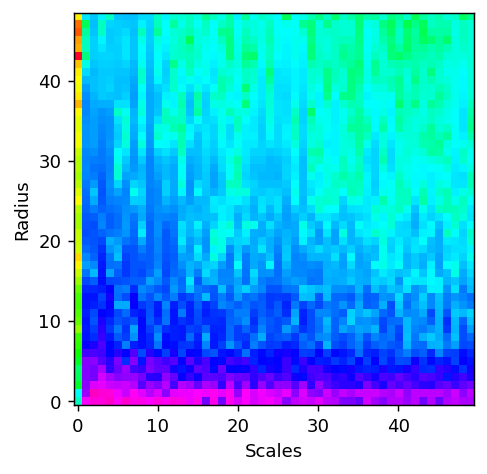

In [227]:
plt.figure(dpi=130)
plt.imshow(np.log10(spec[:,:50]), origin='lower', cmap='gist_rainbow')
plt.xlabel('Scales')
plt.ylabel('Radius')

In [87]:
print(x_m1, y_m1, z_m1)

5.401469042212249 -0.0112837991054081 6.361258060902775e-06


In [88]:
print(x_m2, y_m2, z_m2)

-3.598735521458481 0.007690603354385248 8.346251546826562e-06


In [90]:
nside = 2**3
npix  = healpy.nside2npix(nside)
imap = healpy.vec2pix(nside, x[inds], y[inds], z[inds])

In [91]:
img = np.zeros(npix)

img[imap] += dat[inds]

3072


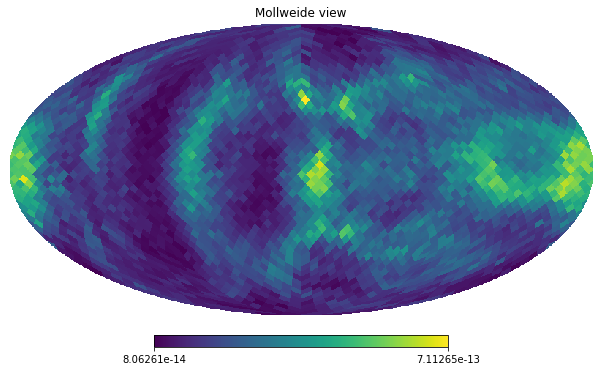

In [104]:
print(npix)

healpy.visufunc.mollview(img) 

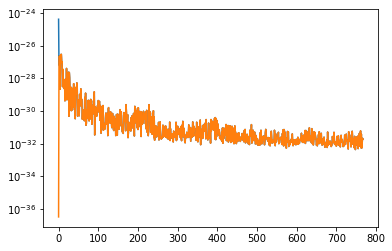

In [230]:
plt.plot(healpy.anafast(img))

plt.plot(healpy.anafast(healpy.remove_monopole(img)))

plt.yscale('log')